<span style="font-family: 'Georgia', serif; font-size: 40px; color: #00000;">Data Preparation</span>

In [1]:
# libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# loading the data
data2022 = pd.read_excel('GLOBAL22.xlsx')
data2023 = pd.read_excel('GLOBAL23.xlsx')

data = pd.concat([data2022, data2023], ignore_index=True)

# checking the data
data.head()

,Date Commande,ID Commande,ID Client,Nom Client,Ville,ID Article,Nom Article,Famille,Sous Famille,Gamme,Quantité,Prix Unit,Total
0,2022-01-03,1,1116,Client 1116,AGADIR,6111251173239,BLOC EPHEMERIDE BLANC REF:550050,BUREAUTIQUE,ACCESSOIRE,LOCAL,10.0,10.5000,105.0000
1,2022-01-03,1,1116,Client 1116,AGADIR,6281073810008,MACHINE SPIRALIEUSE ATLAS REF : AS-BM-PB21,BUREAUTIQUE,MACHINE,ATLAS,1.0,655.6275,655.6275
2,2022-01-03,1,1116,Client 1116,AGADIR,11101101225,CHEMISE A SOUFLET 24X32 SICLA 400PCS/CTN,BUREAUTIQUE,CHEMISE,SICLA,200.0,3.8000,760.0000
3,2022-01-03,1,1116,Client 1116,AGADIR,3112539846626,TONER HP 415A YELLOW ARMOR POUR M454/M479 REF;...,INFORMATIQUE,TONER,ARMOR,2.0,490.0000,980.0000
4,2022-01-03,1,1116,Client 1116,AGADIR,3112539846619,TONER HP 415A MAGENTA ARMOR POUR M454/M479 REF...,INFORMATIQUE,TONER,ARMOR,2.0,490.0000,980.0000


In [3]:
# informations about the data
data.describe()

,Date Commande,ID Commande,ID Client,Quantité,Prix Unit,Total
count,519496,519496.000000,519496.000000,519422.000000,518807.000000,518733.000000
mean,2023-02-10 21:31:33.829403904,29689.230029,514.894103,103.668010,82.231890,624.829153
min,2022-01-03 00:00:00,1.000000,1.000000,-12.000000,-8.200000,-280.000000
25%,2022-08-29 00:00:00,14106.000000,180.000000,2.000000,5.800000,57.600000
50%,2023-02-07 00:00:00,30901.000000,344.000000,8.000000,17.000000,140.000000
75%,2023-08-30 00:00:00,44417.000000,918.000000,32.000000,46.750000,388.800000
max,2023-12-31 00:00:00,59010.000000,1393.000000,108000.000000,268610.000000,333000.000000
std,NaN,16624.138471,406.461647,855.328963,863.131254,3340.974208


<span style="font-family: 'Georgia', serif; font-size: 40px; color: #00000;">Data Cleaning</span>

In [4]:
# Analyze missing values
missing_values = data.isnull().sum()
missing_percentage = (missing_values / len(data)) * 100

print("Missing Values Count:")
print(missing_values)
print("\nMissing Values Percentage:")
print(missing_percentage)

Missing Values Count:
Date Commande        0
ID Commande          0
ID Client            0
Nom Client           0
Ville            87082
ID Article           4
Nom Article          2
Famille             24
Sous Famille      4231
Gamme            10746
Quantité            74
Prix Unit          689
Total              763
dtype: int64

Missing Values Percentage:
Date Commande     0.000000
ID Commande       0.000000
ID Client         0.000000
Nom Client        0.000000
Ville            16.762785
ID Article        0.000770
Nom Article       0.000385
Famille           0.004620
Sous Famille      0.814443
Gamme             2.068543
Quantité          0.014245
Prix Unit         0.132629
Total             0.146873
dtype: float64


In [5]:
# Replace missing values
df = data.fillna({'Ville': "NON SPECIFIED",'Famille': "UNKNOWN",'Nom Article': 
                  "UNKNOWN", 'ID Article': 'UNKNOWN', 'Sous Famille': "UNKNOWN", 'Gamme': "UNKNOWN"})

# Mean imputation for 'Quantité'
df['Quantité'].fillna(df['Quantité'].mean(), inplace=True)

# Mean imputation for 'Prix Unit'
df['Prix Unit'].fillna(df['Prix Unit'].mean(), inplace=True)

# Recalculating 'Total' after imputations
df['Total'] = df['Quantité'] * df['Prix Unit']

df.head(10)

# df.to_csv('data_cleaned.csv', index=False)


<span style="font-family: 'Georgia', serif; font-size: 40px; color: #00000;">Dashboard
 in POWER BI</span>

<span style="font-family: 'Georgia', serif; font-size: 40px; color: #00000;">Feature Engineering</span>

In [6]:
features_df = pd.DataFrame()

# Group data by 'ID Commande' and calculate aggregates
order_data = df.groupby('ID Commande')[['Nom Article', 'Total']].agg(
    Total_Number_of_Items=('Nom Article', 'nunique'),
    Order_Value=('Total', 'sum')
)

# Assign the aggregated results to the features DataFrame
features_df = order_data.copy()

# Order Variety
features_df['Unique Families Ordered'] = df.groupby('ID Commande')['Famille'].nunique()
features_df['Unique Sub-Families Ordered'] = df.groupby('ID Commande')['Sous Famille'].nunique()


# Weekend vs. Weekday
features_df['Weekday'] = df['Date Commande'].dt.dayofweek  

# Convert Weekday numbers to names 
weekday_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
                 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
features_df['Day of Week'] = features_df['Weekday'].map(weekday_dict)


# Popularity Rank (Assuming you want to rank for the entire dataset)
product_sales = df.groupby('Nom Article')['Quantité'].sum().sort_values(ascending=False)
df['Popularity Rank'] = df['Nom Article'].map(product_sales.index.get_loc)
features_df['Popularity Rank'] = df.groupby('ID Commande')['Popularity Rank'].mean() 

features_df.head()

# features_df.to_csv('features_df.csv')


c:\Users\VSS\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


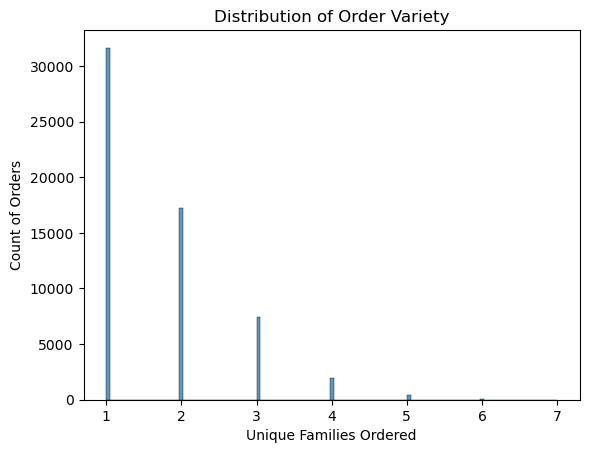

In [7]:
# Histogram of Order Variety
sns.histplot(data=features_df, x='Unique Families Ordered')
plt.xlabel('Unique Families Ordered')
plt.ylabel('Count of Orders')
plt.title('Distribution of Order Variety')
plt.show()

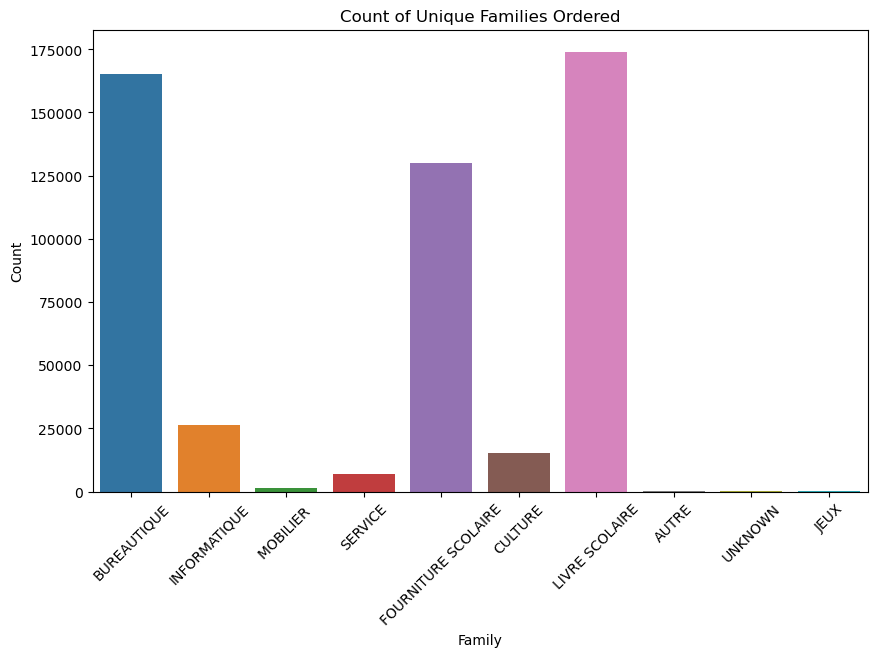

In [8]:
import matplotlib.pyplot as plt

# Count of unique families ordered
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Famille')
plt.xlabel('Family')
plt.ylabel('Count')
plt.title('Count of Unique Families Ordered')
plt.xticks(rotation=45)
plt.show()


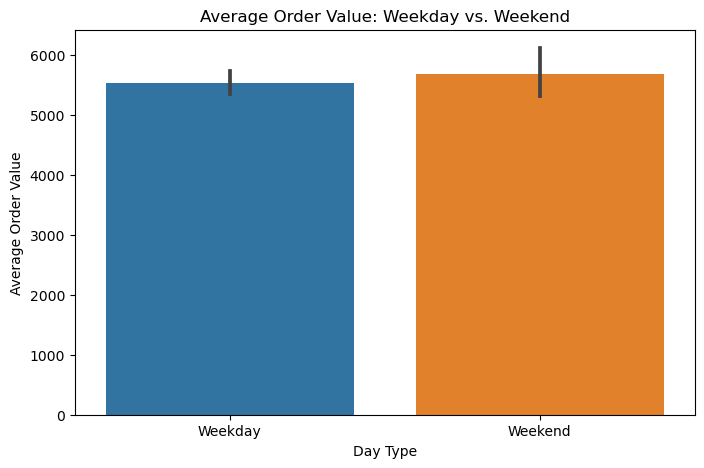

In [9]:
# Weekday/Weekend Comparison (Average Order Value)
features_df['Is_Weekend'] = features_df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)
plt.figure(figsize=(8, 5))
sns.barplot(data=features_df, x='Is_Weekend', y='Order_Value')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.title('Average Order Value: Weekday vs. Weekend')
plt.xlabel('Day Type')
plt.ylabel('Average Order Value')
plt.show()

c:\Users\VSS\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\VSS\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\VSS\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\VSS\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

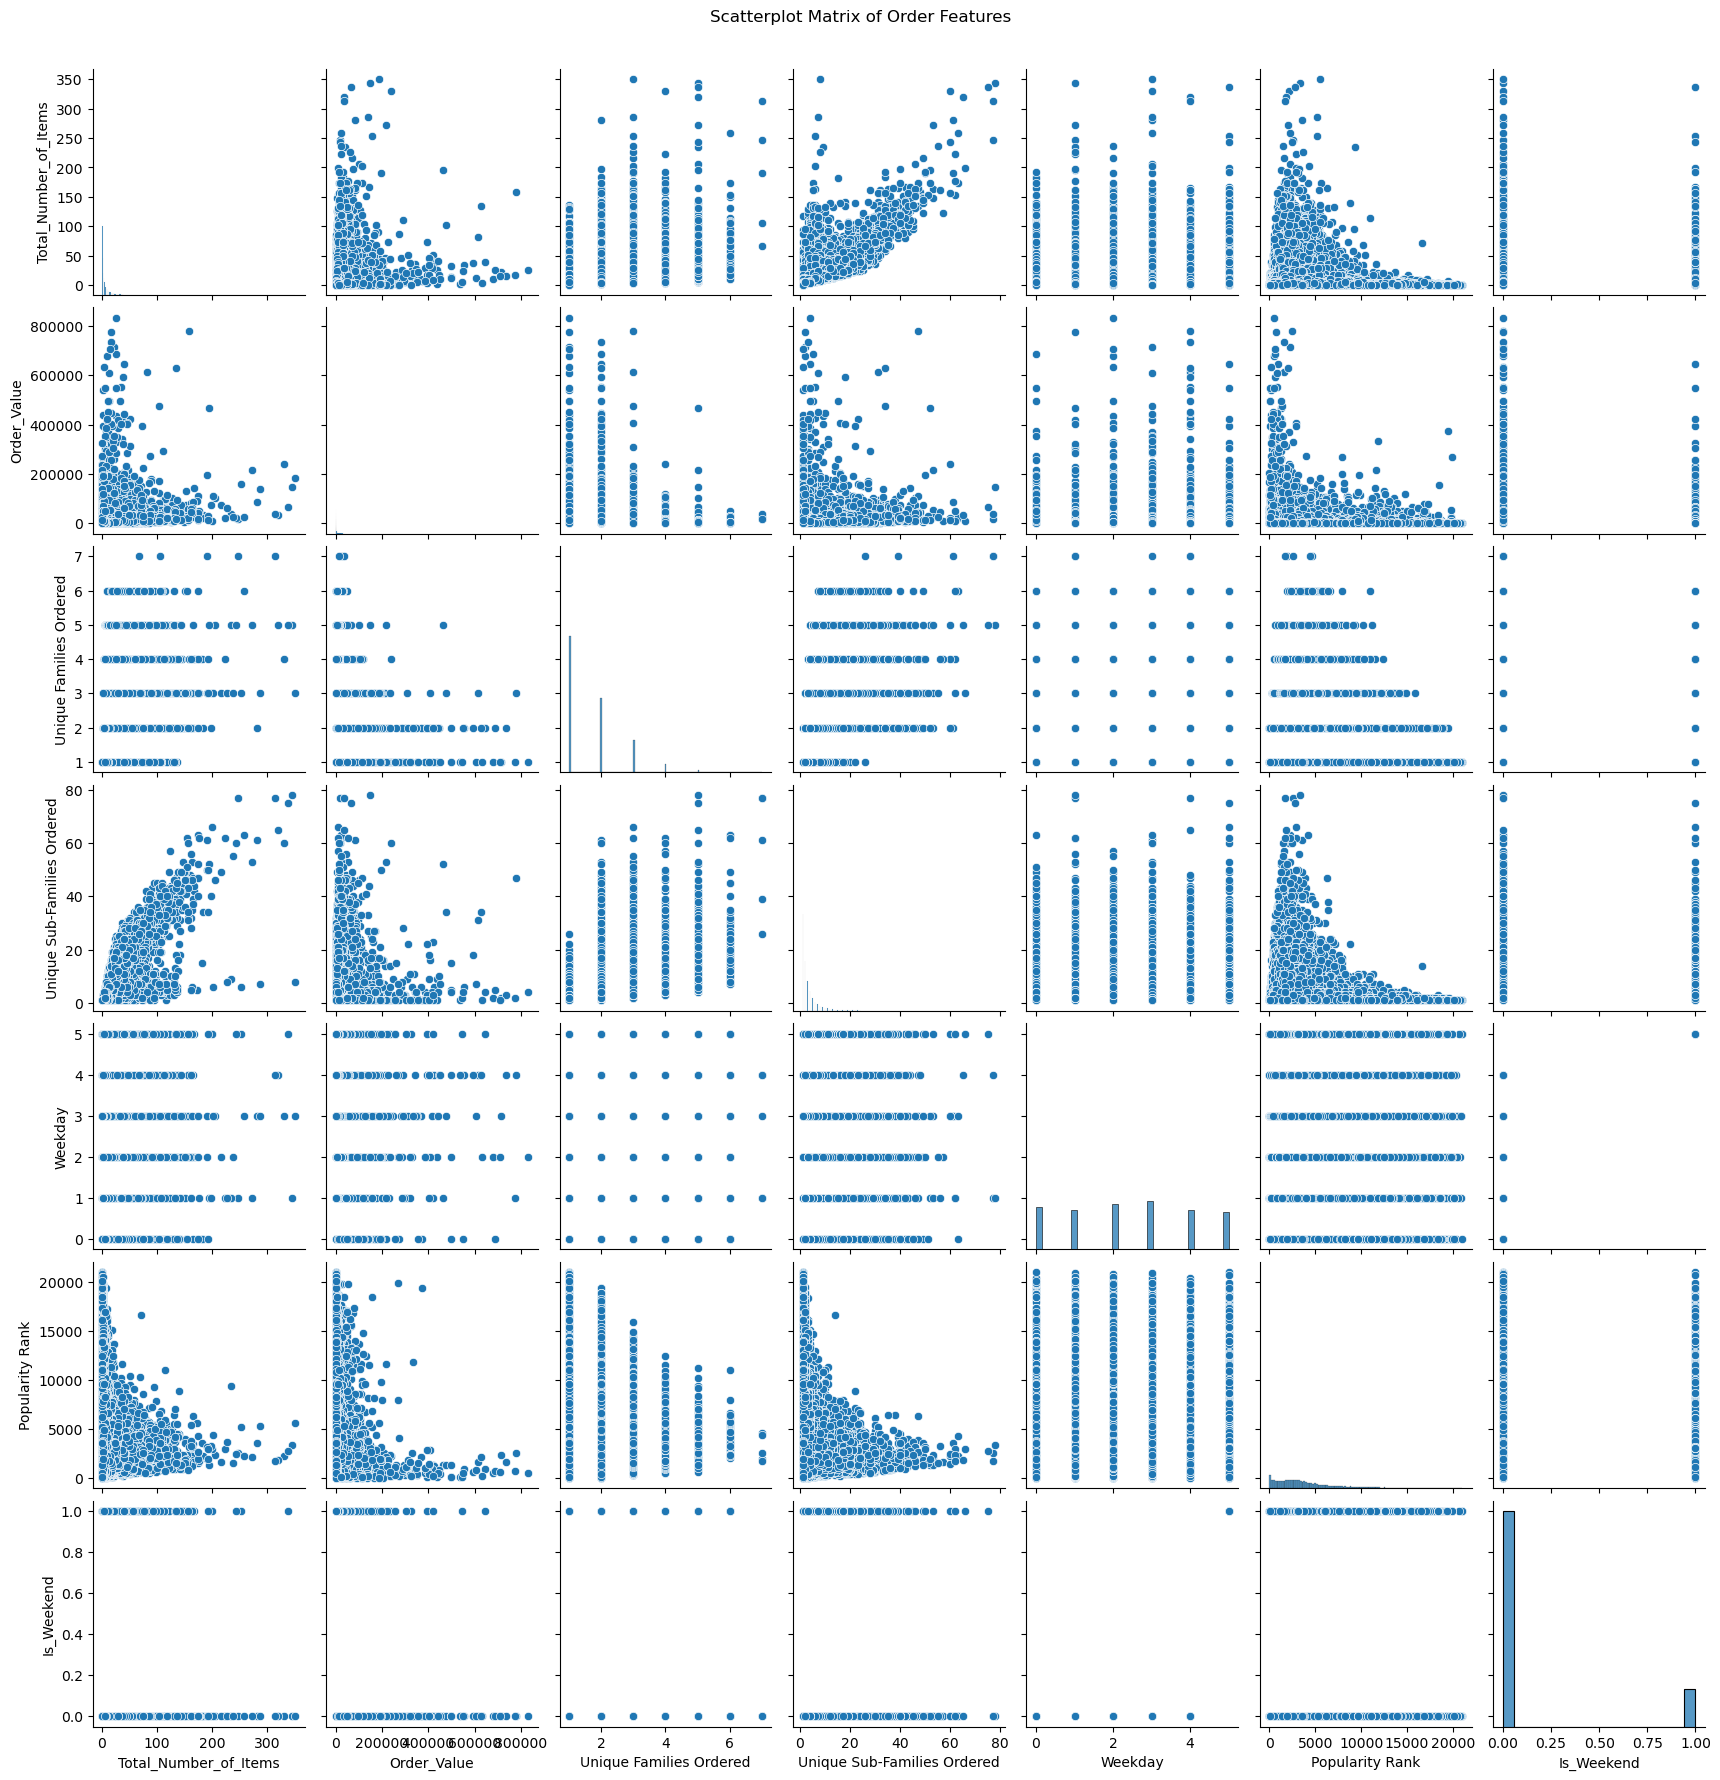

In [10]:
# Scatterplot Matrix (for all numerical features in features_df)
sns.pairplot(features_df)
plt.suptitle('Scatterplot Matrix of Order Features', y=1.02)
plt.show()